# NYPD Allegations

# Summary of Findings


### Introduction & Data Cleaning
In this project, I attempted to build a model that would predict whether or not a filed complaint would be successful (successful meaning the complaint was substantiated). Before delving into building the model, I had to clean my data. The first step in cleaning this dataset is to remove unnecessary columns. More specifically, columns that wouldn't pertain to/be useful in exploring my question. I removed over half of the columns that I felt were unnecessary then moved to exploring the data types of the dataset. The first column I noticed with an odd data type was the "complainant_age_incident" column which was a float rather than an integar. I discovered that this column contained negative values: a huge outlier at -4301.0 and many -1.0's. Ages should be whole positive numbers so these values were definitely a mistake (there could have been a bug in the system when the complainant inputted the numbers). Nevertheless, I converted these values to NaN. I did the same exploration with other columns and didn't find anything that out-of-place.

I also looked for "missing" data that weren't labeled as missing and found many instances of these in more than one column. In the complainant columns, the columns I would be later using, had this error. In the "complainant_ethnicity", there were "Unknown" and "Refused" values which can both be umbrellaed as NaN values since they're really just missing values now. In the "complainant_gender", there was a value "Not described", which is essentially NaN as well. I replaced all these values with NaN's.

One important data cleaning step that would later be very helpful in exploring my question (and also mentioned in the instructions) was to combine the date columns, specifically "month_received", "year_received", "month_closed", and "year_closed". I added 2 new columns -- "date_received" and "date_closed". These two columns would make it easier to compare dates for time-series exploration. However, since only the month and year was provided and not the day, all the entries would have days at 1.
-  |  7  |  2019  |  -->  |  7-01-2019  |

Lastly, I created two extra columns that I would use later - "complaint_length" (in days) and "complaint_successful". For the "complaint_length" column, I used the datetime columns I made earlier to find how long, in days, the complaint took to be resolved / closed. It's important to mention, though, that because all the days are at the beginning of the month, the actual complaint length would be different. The "complaint_length" is thus a close enough appoximation. The "complaint_successful" column is essentially a boolean column that concludes whether or not the complaint was successfully resolved (substantiated) or not (unsubstantiated). This column is important since the "board_disposition" column can really be broken down to a boolean (success/fail) column and would make the hypothesis testing much easier.

These columns I kept were: **mos_ethnicity, mos_gender, mos_age_incident, complaintant_ethnicity, complainant_gender, complaintant_age_incident, complaint_successful, fado_type, and precinct**. The numeric columns are the ages and precinct columns while the rest are categorical (not including the predicted complaint_successful column).

Since I'm trying to make predictions on the complaint_successful column, I decided to use a classifier instead of a regressor, more specifically a Decision Tree Classifier. The target variable will be thus be whether or not a complaint is successful, denoted by 1 (successful) or 0 (unsuccessful). The evaluation metric will also be R2, a score that represents the accuracy of the model where a number closer to 1 means a higher accuracy.

### Baseline Model
For my baseline model, I used 6 columns -- **mos_ethnicity, mos_gender, mos_age_incident, complaintant_ethnicity, complainant_gender, complaintant_age_incident, complaint_successful, fado_type, and precinct**. The quantative columns are mos_age_incident,  complaintant_age_incident, and precinct. The nominal columns are mos_ethnicity, mos_gender, complaintant_ethnicity, complainant_gender, and fado_type. There are no ordinal columns among the columns I chose. Again, I used a Decision Tree Regressor and I first split my data into training and testing sets with a 80/20 split. In order to use all the features I chose, I had to preprocess the data using one hot encoding and standard scaling for the quantative and nominal columns. After adding these transformations into a pipeline, I fit my data and got the following scores:
- training score: 0.92
- testing score: 0.61

As expected, the training score is larger than the testing score which can be due to a variety of reasons. I might need to change the number of features (increase or decrease) or find better parameters for the Decision Tree Classifier such as max_depth, min_samples_leaf, and min_samples_split, all which can solve the possible overfitting of the training data. This, I explored in building the final model.

### Final Model
The first thing I explored was finding better parameters to use for max_depth, min_samples_leaf, and min_samples_split. To do this, I defined some parameters and used GridSearchCV to test different parameter values efficiently. While this can be done manually, it's time-consuming and I can simply use sklearn's GridSearch to do this. More specifically, the number of parameters for max_depth, min_samples_leaf, and min_samples_split are 10, 7, 7, respectively. This comes out to 10*7*7 = 490 calculations per fitting for a 5 cross-validation fold. I can use GridSearchCV(DecisionTreeClassifier, parameters, cv = 5) to do this in one line. I then fit my data to the classifier using the same preprocessing and column transformers in my baseline model. The best parameters were:
- max_depth: 2
- min_samples_leaf: 20
- min_samples_split: 2

Using the best performing parameters, I received the following scores:
- training score: 0.60
- testing score: 0.62

I'm surprised at my results because they're very similar to my initial scores from my baseline model. I was expecting that, with the best parameters, my final model would be much more robust and accurate. I did notice that the training score went down which could point to less overfitting in this final model, but the testing score is essentially the same still. A possible guess is that this final model would perform better with more unknown data since it's not overfitting like the baseline model.

I also attempted to use different features. I removed the mos related columns such as mos_gender, mos_ethnicity, and mos_age_incident columns and only kept the complaintant columns. With these features, the scores were essentially the same as well so I decided to keep all features in my final model. 

### Fairness Evaluation
For my fairnesss evaluation, I decided to evaluate the fairness in the mos_gender column, especially since there's only two unique values in that column (M, F). For my parity measure, I also used the accuracy between the two groups. To evaluate fairness, I need a permutation test with the following H0 and H1:

- Null Hypothesis: My final model is fair and the accuracy for the two groups are essentially the same or negligible. 
- Alternative Hypothesis: My final model is unfair and the accuracy for the female MOS group is higher than the male MOS group.

To compare with my observed value, I ran a permutation test that resampled the mos_gender column N times with the predictions from my final model classifier.  I ran permutation test 100 times to receive 100 test stats and compared to the observed value to receive a p-value of essentially 0.17. Further plotting this p-value to the test stats and with a significance level of 0.05 shows that it not statistically significant and indicates strong evidence for the null hypothesis. We can't accept the null but we can fail to reject it. 



# Code

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing as pp
from sklearn import metrics


### Baseline Model

In [56]:
# Reapply data cleaning from Project 3
fp = os.path.join('data', 'allegations_202007271729.csv')
df = pd.read_csv(fp)

remove_cols = ['first_name', 'last_name', 'command_now', 'shield_no',
 'command_at_incident', 'rank_abbrev_incident', 'rank_abbrev_now',
 'rank_abbrev_now', 'rank_incident', 'outcome_description']

df = df.drop(columns = remove_cols)

df['complainant_age_incident'] = df['complainant_age_incident'].apply(lambda x: x if x > 0 else np.NaN)
df['complainant_ethnicity'] = df['complainant_ethnicity'].replace({'Unknown': np.NaN, 'Refused': np.NaN})
df['complainant_gender'] = df['complainant_gender'].replace('Not described', np.NaN)
df['date_received'] = (df['month_received'].astype(str) + '-' + df['year_received'].astype(str)).apply(pd.to_datetime)
df['date_closed'] = (df['month_closed'].astype(str) + '-' + df['year_closed'].astype(str)).apply(pd.to_datetime)

def complaint_helper(disposition):
    if disposition == 'Unsubstantiated':
        return 0.0
    else:
        return 1.0

df['complaint_successful'] = df['board_disposition'].apply(complaint_helper)
df['complaint_length'] = (df['date_closed'] - df['date_received']) / np.timedelta64(1, 'M')

df.head()

,unique_mos_id,complaint_id,month_received,year_received,month_closed,year_closed,rank_now,mos_ethnicity,mos_gender,mos_age_incident,...,complainant_age_incident,fado_type,allegation,precinct,contact_reason,board_disposition,date_received,date_closed,complaint_successful,complaint_length
0,10004,42835,7,2019,5,2020,Police Officer,Hispanic,M,32,...,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,Substantiated (Command Lvl Instructions),2019-07-01,2020-05-01,1.0,10.020740
1,10007,24601,11,2011,8,2012,Police Officer,White,M,24,...,26.0,Discourtesy,Action,67.0,Moving violation,Substantiated (Charges),2011-11-01,2012-08-01,1.0,9.002238
2,10007,24601,11,2011,8,2012,Police Officer,White,M,24,...,26.0,Offensive Language,Race,67.0,Moving violation,Substantiated (Charges),2011-11-01,2012-08-01,1.0,9.002238
3,10007,26146,7,2012,9,2013,Police Officer,White,M,25,...,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,Substantiated (Charges),2012-07-01,2013-09-01,1.0,14.029036
4,10009,40253,8,2018,2,2019,Police Officer,Hispanic,F,39,...,16.0,Force,Physical force,67.0,Report-dispute,Substantiated (Command Discipline A),2018-08-01,2019-02-01,1.0,6.045299


In [57]:
# Delete more columns and keep relevant features for model
df = df.drop(columns = ['unique_mos_id', 'complaint_id', 'month_received', 
                        'year_received', 'month_closed', 'year_closed', 'rank_now',
                        'allegation', 'contact_reason', 'board_disposition',
                        'date_received', 'date_closed', 'complaint_length']
                        ).reset_index(drop = True).dropna()

df['complainant_age_incident'] = df['complainant_age_incident'].astype(int)

In [58]:
# DecisionTreeRegressor

X = df.drop('complaint_successful', axis=1)
y = df['complaint_successful']

# split dataset into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [90]:
preprocessing = ColumnTransformer(transformers=[
            ('one_hot', OneHotEncoder(drop = 'first'),
            ['mos_ethnicity', 'mos_gender', 'complainant_ethnicity', 'complainant_gender', 'fado_type']), 
            ('standardize', pp.StandardScaler(), ['mos_age_incident', 'complainant_age_incident', 'precinct'])
            ], remainder= 'passthrough')  

pl = Pipeline([('preprocess', preprocessing),
            ('DecisionTreeClassifier', DecisionTreeClassifier())])

pl.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['mos_ethnicity',
                                                   'mos_gender',
                                                   'complainant_ethnicity',
                                                   'complainant_gender',
                                                   'fado_type']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  ['mos_age_incident',
                                                   'complainant_age_incident',
                                                   'precinct'])])),
                ('DecisionTreeClassifier', DecisionTreeClassifier())])

In [91]:
pl.score(X_train, y_train)

0.9191984188996645

In [92]:
pl.score(X_test, y_test)

0.5998161764705883

### Final Model

In [62]:
# We can make the DecisionTreeRegressor more efficient by finding the best parameter to use ... 
parameters = {
    'max_depth': [2,3,4,5,7,10,13,15,18,None],
    'min_samples_leaf':[20,30,50,70,90,100],
    'min_samples_split':[2,3,5,7,10,15,20]

}

In [63]:
preprocessing = ColumnTransformer(transformers=[
            ('one_hot', OneHotEncoder(drop = 'first'),
            ['mos_ethnicity', 'mos_gender', 'complainant_ethnicity', 'complainant_gender', 'fado_type']), 
            ('standardize', pp.StandardScaler(), ['mos_age_incident', 'complainant_age_incident', 'precinct'])
            ], remainder= 'passthrough')  

In [64]:
# Can be done manually but using GridSearch is much faster
clf = GridSearchCV(DecisionTreeClassifier(), parameters, cv = 5)
clf.fit(preprocessing.fit_transform(X_train), y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 7, 10, 13, 15, 18, None],
                         'min_samples_leaf': [20, 30, 50, 70, 90, 100],
                         'min_samples_split': [2, 3, 5, 7, 10, 15, 20]})

In [65]:
clf.best_params_

{'max_depth': 3, 'min_samples_leaf': 30, 'min_samples_split': 2}

In [85]:
preprocessing = ColumnTransformer(transformers=[
            ('one_hot', OneHotEncoder(drop = 'first'),
            ['mos_ethnicity', 'mos_gender', 'complainant_ethnicity', 'complainant_gender', 'fado_type']), 
            ('standardize', pp.StandardScaler(), ['mos_age_incident', 'complainant_age_incident', 'precinct'])
            ], remainder= 'passthrough') 
            
pl = Pipeline([('preprocess', preprocessing),
            ('DecisionTreeClassifier', DecisionTreeClassifier(max_depth = 3,
                                                            min_samples_leaf = 30,
                                                            min_samples_split = 2))])

pl.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['mos_ethnicity',
                                                   'mos_gender',
                                                   'complainant_ethnicity',
                                                   'complainant_gender',
                                                   'fado_type']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  ['mos_age_incident',
                                                   'complainant_age_incident',
                                                   'precinct'])])),
                ('DecisionTreeClassifier',
                 DecisionTr

In [86]:
pl.score(X_train, y_train)

0.6067012915383555

In [87]:
pl.score(X_test, y_test)

0.5976102941176471

### Fairness Evaluation

In [69]:
preds = pl.predict(X_test)

X_tst = X_test.copy()
X_tst['preds'] = preds
X_tst['actual'] = y_test
X_tst

,mos_ethnicity,mos_gender,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,precinct,preds,actual
3,White,M,25,Black,Male,45,Abuse of Authority,67.0,1.0,1.0
2426,Hispanic,M,31,Other Race,Male,34,Abuse of Authority,17.0,1.0,1.0
21087,White,F,29,Hispanic,Male,15,Force,73.0,1.0,1.0
1904,White,M,28,Other Race,Male,20,Abuse of Authority,101.0,1.0,0.0
553,White,M,29,Black,Male,29,Force,79.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
13451,White,M,34,Black,Male,21,Force,25.0,1.0,0.0
24854,White,M,25,Black,Male,23,Abuse of Authority,23.0,0.0,0.0
23577,Hispanic,M,34,Hispanic,Male,34,Abuse of Authority,6.0,1.0,0.0
27681,White,M,34,Black,Male,25,Discourtesy,44.0,0.0,0.0


In [70]:
# Accuracy Parity
(
    X_tst
    .groupby('mos_gender')
    .apply(lambda x: metrics.accuracy_score(x.actual, x.preds))
    .rename('accuracy')
    .to_frame()
)

,accuracy
mos_gender,
F,0.628834
M,0.594447


In [71]:
obs = X_tst.groupby('mos_gender').apply(lambda x: metrics.accuracy_score(x.actual, x.preds)).diff().iloc[-1]
obs

-0.03438773869877232

In [72]:
test_stats = []
for i in range(100):
    s = (
        X_tst[['mos_gender', 'preds', 'actual']]
        .assign(mos_gender=X_tst.mos_gender.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('mos_gender')
        .apply(lambda x: metrics.accuracy_score(x.actual, x.preds))
        .diff()
        .iloc[-1]
    )
    
    test_stats.append(s)
test_stats[:10]

[-0.06000000000000005,
 -0.16224744608399544,
 0.03315412186379929,
 0.05929209919261824,
 0.029698302954116906,
 0.06814709539882746,
 0.07213142446893872,
 -0.05197132616487454,
 -0.06149898927071995,
 0.038978185993111314]

In [73]:
(test_stats < obs).mean()

0.26

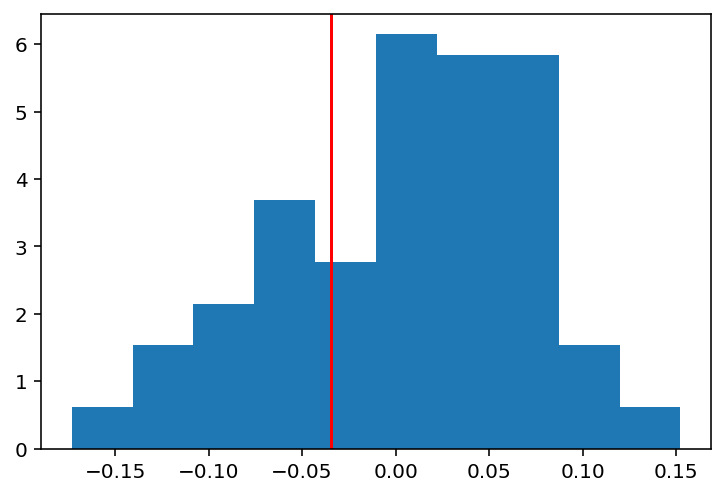

In [74]:
p_val_hist = plt.hist(test_stats, density=True)
plt.axvline(x = obs, color = 'red')
plt.show()